In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import pyplot as plt
%matplotlib widget
import pandas as pd

The beginning of this notebook is somewhat similar to `viz_segment6.ipynb` because it loads up the turning points and the hash codes.

In [3]:
# Load the hash_master file
hash_df = pd.read_csv('../data/osstate/routes_hashes/hash_master.hashb', header=None, names=['wpf', 'wpt', 'hash'])
print(f"There are {len(hash_df)} rows")
hash_df.head()

There are 19466 rows


,wpf,wpt,hash
0,BdqjF4kdoWuF,FEQqm0pwCiHB,06355708377841511e89a4d57999c81ca8f7ac7d3ad371...
1,fsfzvUfF161g,g8jG0jNTYLWh,8635571817e841751e89a4c579ddc89c88f6a8753a1351...
2,TizH2bRw7vGs,xzpBLhCfzUsF,8225571897e841751f09a4c779dd889c88f6a8753a1211...
3,EThpIE3IBmHj,GPvokn2TQRgr,f044a2d69c87bf3e57775a2ab6f424ea55bc43031d2c8e...
4,uQXbsh0Pt5dR,Hoalau7wsbpF,f024335694c72f3457537aa637f404ea55bcc013192c8a...


In [4]:
hash_unique = hash_df['hash'].unique()
print('Number of unique hashes:', len(hash_unique))

Number of unique hashes: 470


In [5]:
# Rank the hashes by the number of times they appear
hash_counts = hash_df['hash'].value_counts()
hash_counts = hash_counts.sort_values(ascending=False)
hash_counts.head(10)


hash
f04432569487bf3e57775a2ab7f404ea55bcc1131d2c8ebaeadfc8e121934e9e8663f26847fdcc27c9cfeee8a76abeec7e39d55c7973cc99467abfc5_6f5    1776
8635570817e841751e89a4c579ddc89c88f6a8753a535102254d648c7c5e0511d53e836fdac2f7e7f287523e991367faccc70bc100d2749b261d10da_8b3     691
8225571897e041751f09a4c779dd889c88f6a8753a101102254d64907c5e0511d56ec36fdec2e7e7f287d63e991b77facc470bc029d2749b061f12db_8f3     575
8635571817e841751e89a4c579ddc89c88f6a8753a135102254d649c7c5e0511d53ec36fdec2f7e7f287d23e991b77faccc70bc109d2749b261d10da_8b3     552
8225571a97c041751f49a4c779dd8cfc98fee87538101382255d64907f5a0413d76ed36bdef2e7a7e287d63e994b76face470b5029d25c9b061e12db_8f3     552
8225571897e841751f09a4c779dd889c88f6a8753a121102254d64907c5e0511d56ec36fdec2e7e7f287d63e991b77facc470bc029d2749b061f12db_8f3     527
06355718176841711e89a4c559ddc89ca8f6a8753a535102254d649c7e5e1511d53e836fdac2f7e7f287523e991367faccc70bc100d2749b261d10da_8b3     463
a225571e97c043751741a4877ddd8cfcd8bee8773810129225dd64907d5a0413

In [6]:
# Load the waypoints_master file
wp_df = pd.read_csv('../data/osstate/waypoints_master.csv')
wp_df.head()

,ident,lat,lon
0,H882U2Xn5VOd,50.404884,-98.626030
1,P8ToOqoOwy3c,32.375521,130.663520
2,oZYSGKN80id2,41.086054,-77.855456
3,uPuRzZYavxw1,40.908554,-78.007263
4,lEf9PODPqPxe,40.573301,-78.509674


# Stitching for CONUS

In [7]:
region = 'conus'
def get_region_bounds(region: str) -> tuple:
    # Get the geographical boundaries for the map 
    if region=='conus':
        # Contiguous United States
        lat_bounds = [23, 51]
        lon_bounds = [-130, -65]
    elif region=='europe':
        # Europe, from Portugal to Greece, not including Russia
        lat_bounds = [34, 72]        
        lon_bounds = [-32, 40]
    else:
        raise ValueError(f"Region {region} not recognized. Use 'conus' or 'europe'.")
    
    return lat_bounds, lon_bounds

lat_bounds, lon_bounds = get_region_bounds(region)

In [8]:
busiest_airports = {
    "KATL": {"name": "Hartsfield-Jackson Atlanta International Airport", "lat": 33.6407, "lon": -84.4277},
    "KLAX": {"name": "Los Angeles International Airport", "lat": 33.9416, "lon": -118.4085},
    "KORD": {"name": "Chicago O'Hare International Airport", "lat": 41.9742, "lon": -87.9073},
    "KDFW": {"name": "Dallas/Fort Worth International Airport", "lat": 32.8998, "lon": -97.0403},
    "KDEN": {"name": "Denver International Airport", "lat": 39.8561, "lon": -104.6737},
    "KJFK": {"name": "John F. Kennedy International Airport", "lat": 40.6413, "lon": -73.7781},
    "KSFO": {"name": "San Francisco International Airport", "lat": 37.7749, "lon": -122.4194},
    "KSEA": {"name": "Seattle-Tacoma International Airport", "lat": 47.6062, "lon": -122.3321},
    "KLAS": {"name": "Las Vegas McCarran International Airport", "lat": 36.0840, "lon": -115.1537},
    "KMCO": {"name": "Orlando International Airport", "lat": 28.4312, "lon": -81.3081},
    "KPHX": {"name": "Phoenix Sky Harbor International Airport", "lat": 33.4342, "lon": -112.0116},
    "KMIA": {"name": "Miami International Airport", "lat": 25.7959, "lon": -80.2870},
    "KIAH": {"name": "George Bush Intercontinental Airport", "lat": 29.9902, "lon": -95.3368},
    "KMSP": {"name": "Minneapolis-Saint Paul International Airport", "lat": 44.8833, "lon": -93.2040},
    "KBOS": {"name": "Logan International Airport", "lat": 42.3656, "lon": -71.0096},
    "KDCA": {"name": "Ronald Reagan Washington National Airport", "lat": 38.8512, "lon": -77.0402},
    "KIAD": {"name": "Washington Dulles International Airport", "lat": 38.9531, "lon": -77.4565},
    "KPHL": {"name": "Philadelphia International Airport", "lat": 39.8744, "lon": -75.2424},
    "KBWI": {"name": "Baltimore/Washington International Thurgood Marshall Airport", "lat": 39.1754, "lon": -76.6684},
    "KSLC": {"name": "Salt Lake City International Airport", "lat": 40.7899, "lon": -111.9791}
}

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [01:02<00:00, 10.43s/it]


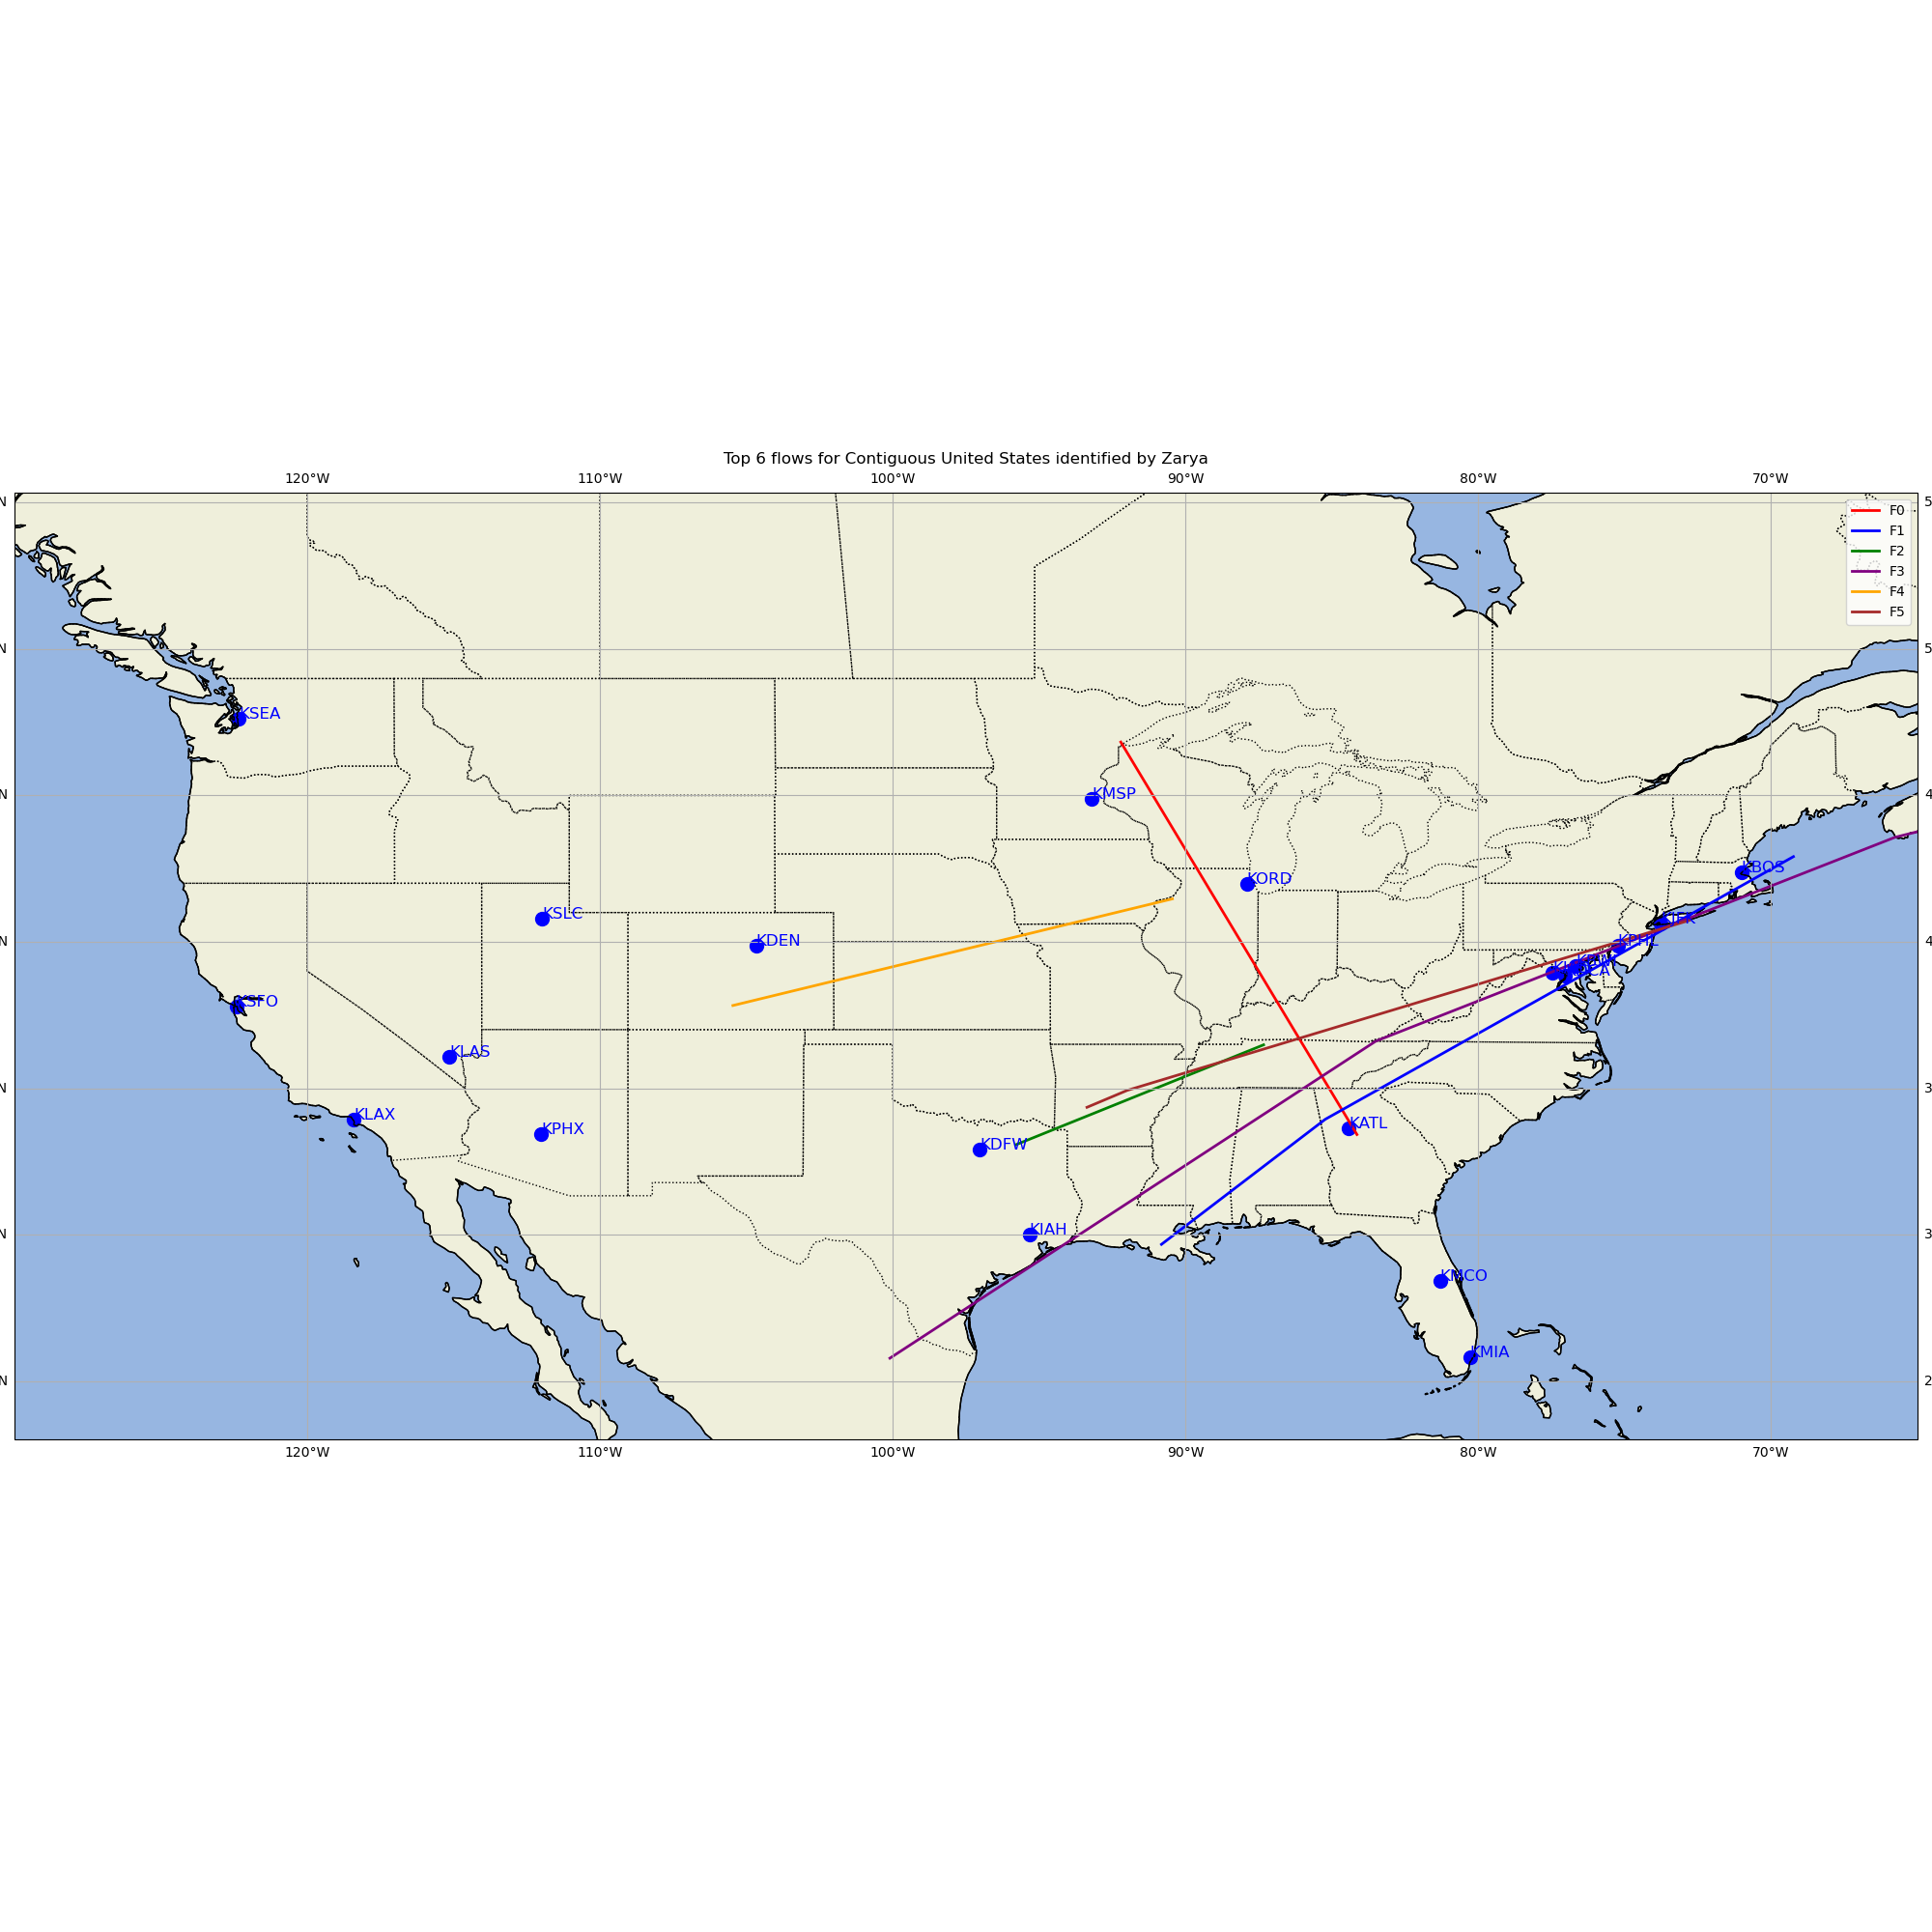

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/mplcursors/_pick_info.py:162: UserWarning: Pick support for FeatureArtist is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")
/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/mplcursors/_pick_info.py:162: UserWarning: Pick support for FeatureArtist is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")
/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/mplcursors/_pick_info.py:162: UserWarning: Pick support for FeatureArtist is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")
/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/mplcursors/_pick_info.py:162: UserWarning: Pick support for FeatureArtist is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")
/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/mplcursors/_pick_info.py:162: UserWarni

In [10]:
from stitcher import get_flow
import warnings
import cartopy.crs as ccrs
import cartopy.feature
warnings.filterwarnings("ignore", category=FutureWarning) # to get rid of pyproj warnings
color_codes = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

from tqdm import tqdm
import mplcursors

def visualize_flows(region, hash_counts, hash_df, wp_df, n_first_hashes = 20):
    # Get the top n_plots hash values
    hash_values = hash_counts.head(n_first_hashes).index

    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

    lat_bounds, lon_bounds = get_region_bounds(region)

    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    for i in tqdm(range(n_first_hashes)):
        res = get_flow(hash_counts, i, hash_df, wp_df, n_segments_to_sample = 100, region = region, eps=1e6)
        if res is None:
            continue # probably due to hashes outside of the region
        sm_start, sm_end = res # unpack the result
        # print(f"Found flow {i}: {sm_start} -> {sm_end}")
        # Plot the great circle going through sm_start and sm_end
        color = color_codes[i % len(color_codes)]
        ax.plot([sm_start[1], sm_end[1]], [sm_start[0], sm_end[0]], color=color, linewidth=2, transform=ccrs.Geodetic(), label=f'F{i}')

    # Add map features
    ax.coastlines()
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    if region == 'conus':
        # Add state borders
        ax.add_feature(cartopy.feature.STATES, linestyle=':')
        plt.title(f'Top {n_first_hashes} flows for Contiguous United States identified by Zarya')
    elif region == 'europe':
        # Add country borders
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        plt.title(f'Top {n_first_hashes} flows for Europe identified by Zarya')
    plt.tight_layout()
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable=None)
    # Show gridlines
    ax.gridlines(draw_labels=True)
    # Scatter plot the busiest airports
    for airport, data in busiest_airports.items():
        ax.scatter(data['lon'], data['lat'], color='blue', s=100, transform=ccrs.PlateCarree())
        ax.text(data['lon'], data['lat'], airport, transform=ccrs.PlateCarree(), fontsize=12, color='blue')
    # Add mplcursors to make it interactive
    cursor = mplcursors.cursor(hover=True)
    # Annotate with the legend label when hovering over a curve
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(sel.artist.get_label())
    plt.legend()
    plt.show()

visualize_flows('conus', hash_counts, hash_df, wp_df, n_first_hashes = 6)